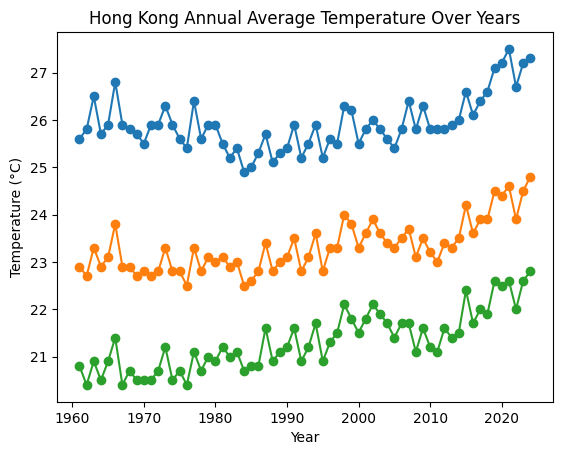

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#read and show hk temperature data
avg_temp = pd.read_csv('hktemp.csv')
#using plt show high avg avg and low avg temperature
plt.plot(avg_temp['Year'], avg_temp['avg_high_temp'], marker='o', label='High Avg Temp')
plt.plot(avg_temp['Year'], avg_temp['avg_temp'], marker='o', label='Avg Temp')
plt.plot(avg_temp['Year'], avg_temp['avg_low_temp'], marker='o', label='Low Avg Temp')
plt.title('Hong Kong Annual Average Temperature Over Years')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.show()

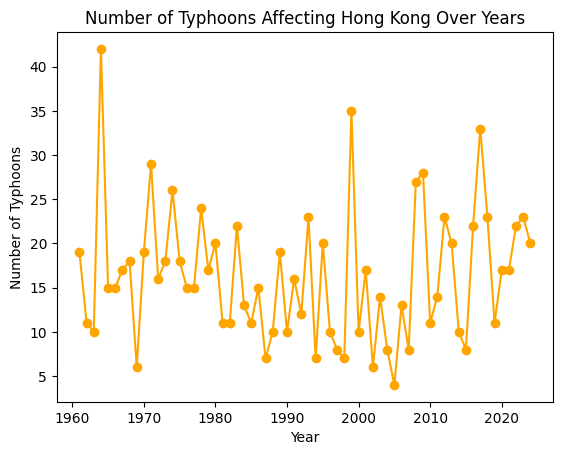

In [6]:
#read and show hk typhoon data
typhoon_num = pd.read_csv('hktyphoon.csv')
combine_list = typhoon_num['1'] + typhoon_num['3'] + typhoon_num['8_Total'] + typhoon_num['9'] + typhoon_num['10']
plt.plot(typhoon_num['Year'], combine_list, marker='o', color='orange')
plt.title('Number of Typhoons Affecting Hong Kong Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Typhoons')
plt.show()

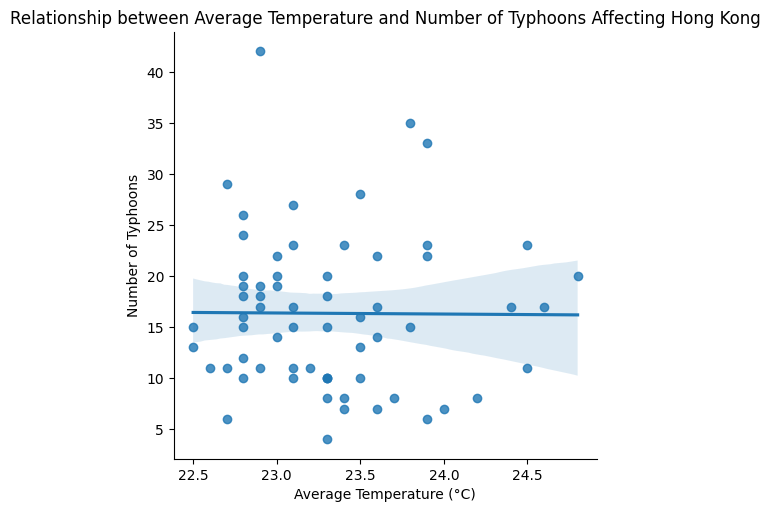

In [7]:
#Relationship between Temperature and Typhoon Numbers
#Linear/Logistic Regression with output graphs 
import seaborn as sns
# Merge temperature and typhoon data on Year
merged_data = pd.merge(avg_temp, typhoon_num, on='Year')
# Calculate total typhoons affecting Hong Kong
merged_data['Total_Typhoons'] = merged_data['1'] + merged_data['3'] + merged_data['8_Total'] + merged_data['9'] + merged_data['10']
# Plot relationship between average temperature and total typhoons
sns.lmplot(x='avg_temp', y='Total_Typhoons', data=merged_data)
plt.title('Relationship between Average Temperature and Number of Typhoons Affecting Hong Kong')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Number of Typhoons')
plt.show()


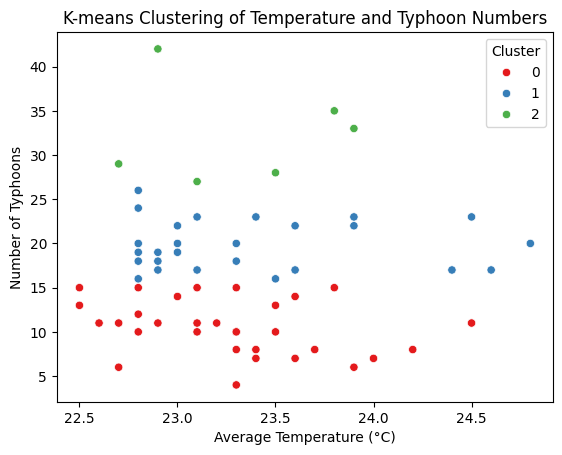

In [8]:
#K-means then output as plt.show
from sklearn.cluster import KMeans
kmeans_data = merged_data[['avg_temp', 'Total_Typhoons']].dropna()
kmeans = KMeans(n_clusters=3)
kmeans.fit(kmeans_data)
kmeans_data['Cluster'] = kmeans.labels_
sns.scatterplot(x='avg_temp', y='Total_Typhoons', hue='Cluster', data=kmeans_data, palette='Set1')
plt.title('K-means Clustering of Temperature and Typhoon Numbers')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Number of Typhoons')
plt.show()
 


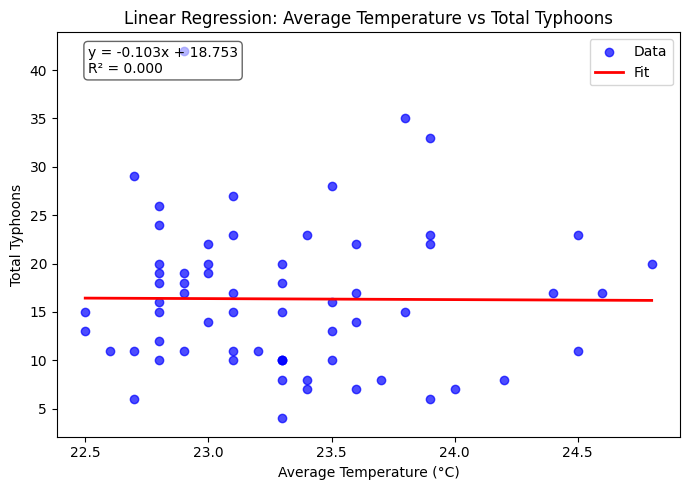

In [9]:
# Linear Regression: Average Temperature vs Total Typhoons
import numpy as np
from sklearn.linear_model import LinearRegression

# Drop rows with missing values to avoid fit/plot issues
_subset = merged_data[["avg_temp", "Total_Typhoons"]].dropna()
X = _subset[["avg_temp"]].values
y = _subset["Total_Typhoons"].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Metrics and parameters
r2 = model.score(X, y)
coef = model.coef_[0]
intercept = model.intercept_

# Sort X for a clean regression line
order = np.argsort(X[:, 0])
X_sorted = X[order]
y_pred_sorted = y_pred[order]

plt.figure(figsize=(7, 5))
plt.scatter(X, y, color="blue", alpha=0.7, label="Data")
plt.plot(X_sorted, y_pred_sorted, color="red", linewidth=2, label="Fit")

plt.xlabel("Average Temperature (°C)")
plt.ylabel("Total Typhoons")
plt.title("Linear Regression: Average Temperature vs Total Typhoons")
plt.legend()

# Annotate equation and R^2 on the plot
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
label_text = f"y = {coef:.3f}x + {intercept:.3f}\nR² = {r2:.3f}"
plt.text(
    xmin + 0.05 * (xmax - xmin),
    ymax - 0.1 * (ymax - ymin),
    label_text,
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.6),
)

plt.tight_layout()
plt.show()

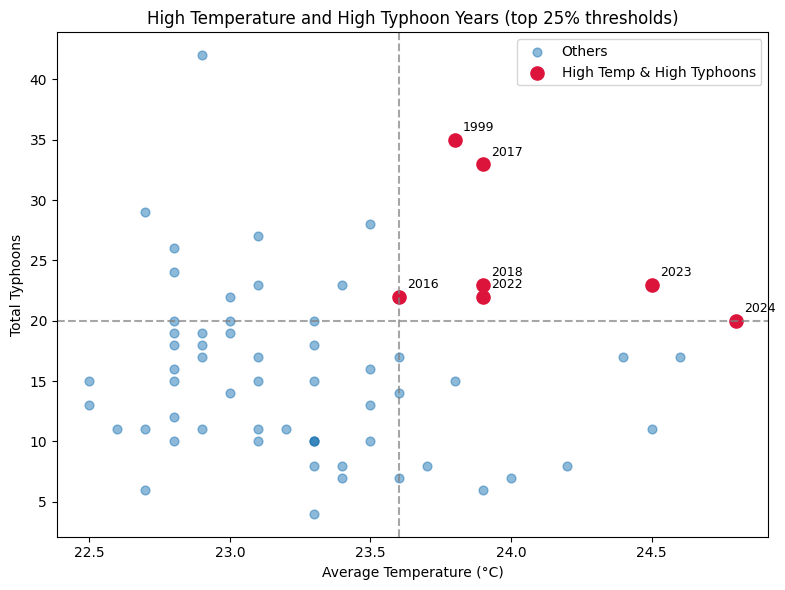

High temp & high typhoon years (q=0.75): 1999, 2016, 2017, 2018, 2022, 2023, 2024


In [10]:
# Highlight years with both high temperature and high typhoon counts
import numpy as np
import matplotlib.pyplot as plt

# Work on a clean subset
_df = merged_data[["Year", "avg_temp", "Total_Typhoons"]].dropna().copy()

# Use 75th percentile as thresholds (adjust q if needed)
q = 0.75
temp_thresh = _df["avg_temp"].quantile(q)
typh_thresh = _df["Total_Typhoons"].quantile(q)

_df["is_high_temp"] = _df["avg_temp"] >= temp_thresh
_df["is_high_typh"] = _df["Total_Typhoons"] >= typh_thresh
hi_hi = _df[_df["is_high_temp"] & _df["is_high_typh"]]

plt.figure(figsize=(8, 6))
plt.scatter(_df["avg_temp"], _df["Total_Typhoons"], s=40, alpha=0.5, label="Others")
plt.scatter(hi_hi["avg_temp"], hi_hi["Total_Typhoons"], color="crimson", s=90, label="High Temp & High Typhoons")

# Threshold guide lines
plt.axvline(temp_thresh, color="gray", linestyle="--", alpha=0.7)
plt.axhline(typh_thresh, color="gray", linestyle="--", alpha=0.7)

# Annotate highlighted years
for _, r in hi_hi.iterrows():
    plt.annotate(int(r["Year"]), (r["avg_temp"], r["Total_Typhoons"]),
                 textcoords="offset points", xytext=(6, 6), fontsize=9)

plt.title("High Temperature and High Typhoon Years (top 25% thresholds)")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Total Typhoons")
plt.legend()
plt.tight_layout()
plt.show()

# Print the list of years for reference
years_list = ", ".join(str(int(y)) for y in hi_hi["Year"].tolist())
print(f"High temp & high typhoon years (q={q:.2f}): {years_list}")

Threshold (q=0.75) for High Typhoons: 20.00
Accuracy:  0.562
Precision: 0.000
Recall:    0.000
F1-score:  0.000

Confusion Matrix:
 [[9 2]
 [5 0]]

Classification Report:
               precision    recall  f1-score   support

         Low       0.64      0.82      0.72        11
        High       0.00      0.00      0.00         5

    accuracy                           0.56        16
   macro avg       0.32      0.41      0.36        16
weighted avg       0.44      0.56      0.49        16



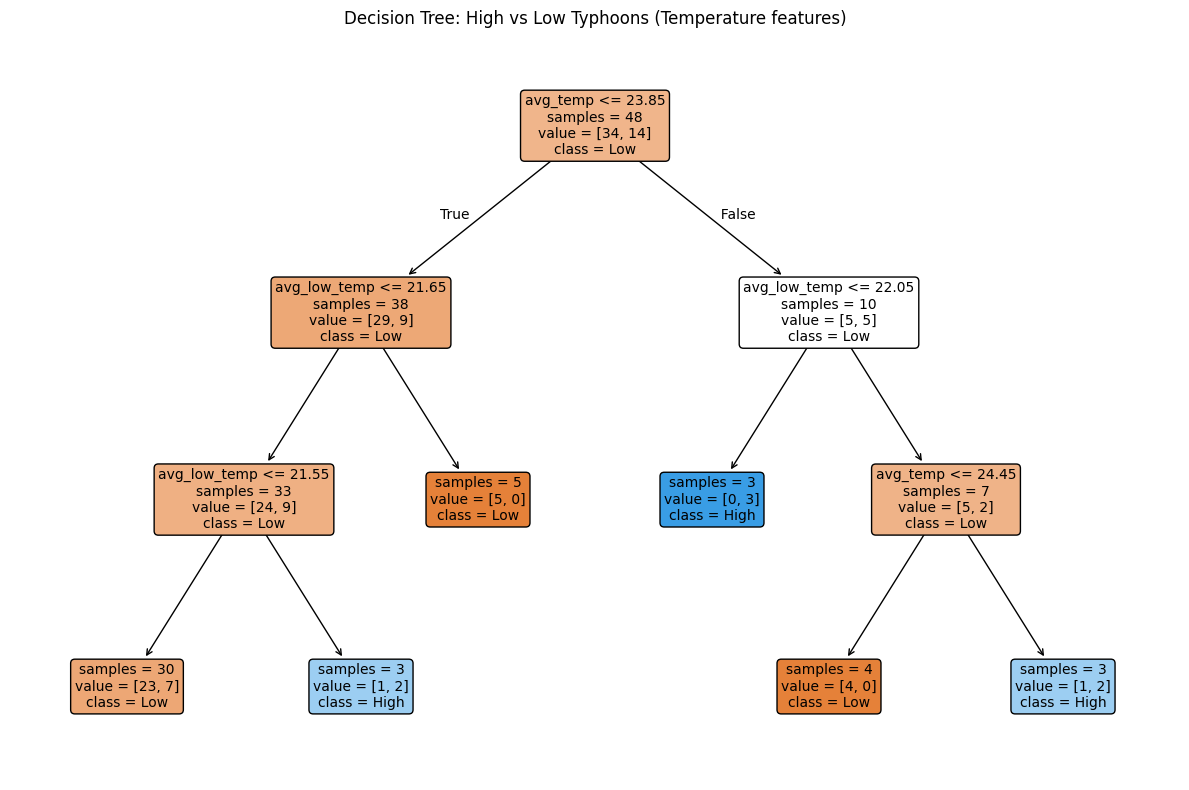

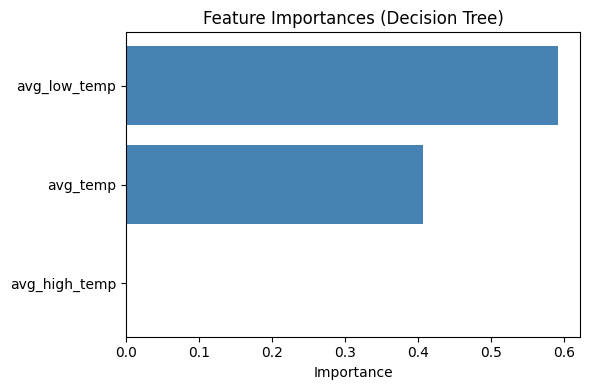

In [11]:
# Train a Decision Tree to classify High-Typhoon years using temperature features only
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Prepare dataset
cols = ["avg_high_temp", "avg_temp", "avg_low_temp", "Total_Typhoons"]
dt_df = merged_data[cols].dropna().copy()

# Binary target: High if >= 75th percentile of Total_Typhoons
q = 0.75
typh_thresh = dt_df["Total_Typhoons"].quantile(q)
y = (dt_df["Total_Typhoons"] >= typh_thresh).astype(int).values
X = dt_df[["avg_high_temp", "avg_temp", "avg_low_temp"]].values
feature_names = ["avg_high_temp", "avg_temp", "avg_low_temp"]
class_names = ["Low", "High"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Train Decision Tree (shallow depth for interpretability)
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Threshold (q={q:.2f}) for High Typhoons: {typh_thresh:.2f}")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

# Plot tree
plt.figure(figsize=(12, 8))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    impurity=False,
    fontsize=10,
)
plt.title("Decision Tree: High vs Low Typhoons (Temperature features)")
plt.tight_layout()
plt.show()

# Feature importance
importances = clf.feature_importances_
plt.figure(figsize=(6, 4))
order = np.argsort(importances)
plt.barh(np.array(feature_names)[order], importances[order], color="steelblue")
plt.xlabel("Importance")
plt.title("Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()